# Network Traffic Classification with Deep Learning

This project explores how deep neural networks can classify different types of internet traffic based on structured feature data. The dataset contains seven categories of traffic, each representing a distinct online activity:

- **Web Browsing**
- **Chat**
- **Streaming**
- **Email**
- **VoIP**
- **Peer-to-Peer (P2P)**
- **File Transfer (FT)**

The goal of this notebook is to understand how well neural models can distinguish between these traffic types and how different modelling choices influence performance.

Throughout the notebook, we:

- Load and inspect the dataset  
- Train baseline and improved multi-class neural networks  
- Compare different optimisers (SGD, RMSprop, Adam)  
- Visualise model performance using confusion matrices and accuracy curves  
- Examine the effect of dataset restrictions (VPN-only, Non-VPN-only)  
- Explore a binary classification version of the problem (VPN vs Non-VPN)  
- Analyse results and highlight potential improvements

This is the table of traffic types I will be using in my notebook.

| Traffic | Content |
|---------|---------|
| Web Browsing | Firefox and Chrome |
| Chat | ICQ, AIM, Skype, Facebook and Hangouts | 
| Streaming | Vimeo and Youtube | 
| Email | SMPTS, POP3S and IMAPS | 
| VoIP |Facebook, Skype and Hangouts voice calls (1h duration) | 
| P2P | uTorrent and Transmission (Bittorrent) |
| FT (File Transfer) | Skype, FTPS and SFTP using Filezilla and an external service | 

Note that there are **two** collections of datasets: one for traffic sent over a VPN, and one for traffic not sent over a VPN. Each collection has training, validation, and test data.

## Setup

In this section we import the required libraries and load the dataset into training, validation, and test splits. The TensorFlow `tf.data` pipeline is used to create efficient, batched datasets that can be passed directly to the neural network models.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils

import os
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML, display

## Loading and preparing the dataset

This section of the notebook loads the dataset and makes it available for training.

First, we define some constants we will use later and define some metrics to use for model evaluation.

In [2]:
BATCH_SIZE = 64

In [3]:
class_names = {i: n.strip() for i, n in enumerate(open('/datasets/cybersecurity/vpn-nonvpn/class_names.txt'))}
class_names

{0: 'BROWSING',
 1: 'CHAT',
 2: 'STREAMING',
 3: 'MAIL',
 4: 'VOIP',
 5: 'P2P',
 6: 'FT'}

In [4]:
class_names_array = np.array([class_names[i] for i in sorted(class_names)])
class_names_array

array(['BROWSING', 'CHAT', 'STREAMING', 'MAIL', 'VOIP', 'P2P', 'FT'],
      dtype='<U9')

In [5]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan=10}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for cn in class_names.values():
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += '<th rowspan=11>Actual labels</th>\n'

    for ai, an in class_names.items(): # enumerate(class_names):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in class_names.items(): #enumerate(class_names):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

In [6]:
def multi_class_precision(cmatrix):
    s = cmatrix.shape[0]
    numerator = tf.reduce_sum(tf.linalg.diag(tf.ones(s)) * cmatrix, axis=0)
    denominator = tf.cast(tf.reduce_sum(cmatrix, axis=0), tf.float32)
    return numerator / denominator

In [7]:
def multi_class_recall(cmatrix):
    s = cmatrix.shape[0]
    numerator = tf.reduce_sum(tf.linalg.diag(tf.ones(s)) * cmatrix, axis=1)
    denominator = tf.cast(tf.reduce_sum(cmatrix, axis=1), tf.float32)
    return numerator / denominator

Where to find the data.

In [8]:
base_dir = '/datasets/cybersecurity/vpn-nonvpn/'

In [9]:
train_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_train'))
train_vpn_data = train_vpn_data.cache()
train_vpn_data = train_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_vpn_data = train_vpn_data.shuffle(1000)
train_vpn_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [10]:
validation_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_validation'))
validation_vpn_data = validation_vpn_data.cache()
validation_vpn_data = validation_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
validation_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [11]:
test_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_test'))
test_vpn_data = test_vpn_data.cache()
test_vpn_data = test_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
test_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [12]:
train_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_train'))
train_no_vpn_data = train_no_vpn_data.cache()
train_no_vpn_data = train_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_no_vpn_data = train_no_vpn_data.shuffle(1000)
train_no_vpn_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [13]:
validation_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_validation'))
validation_no_vpn_data = validation_no_vpn_data.cache()
validation_no_vpn_data = validation_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
validation_no_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [14]:
test_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_test'))
test_no_vpn_data = test_no_vpn_data.cache()
test_no_vpn_data = test_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
test_no_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [15]:
input_shape = (train_vpn_data.element_spec[0].shape[1],)
num_classes = train_vpn_data.element_spec[1].shape[1]
input_shape, num_classes

((23,), 7)

## Validation and Test Labels

In this section, we extract the ground-truth labels from the validation and test datasets.  
These label arrays will be used later when generating evaluation metrics such as confusion matrices and ROC curves.


In [16]:
validation_vpn_labels = np.array(list(validation_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_vpn_labels = np.argmax(validation_vpn_labels, axis=1)
validation_vpn_labels.shape

(979,)

In [17]:
validation_no_vpn_labels = np.array(list(validation_no_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_no_vpn_labels = np.argmax(validation_no_vpn_labels, axis=1)
validation_no_vpn_labels.shape

(896,)

In [18]:
test_vpn_labels = np.array(list(test_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_vpn_labels = np.argmax(test_vpn_labels, axis=1)
test_vpn_labels.shape

(1958,)

In [19]:
test_no_vpn_labels = np.array(list(test_no_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_no_vpn_labels = np.argmax(test_no_vpn_labels, axis=1)
test_no_vpn_labels.shape

(1792,)

## Baseline Multi-Class Model

To establish a starting point for the multi-class classification task, we build a simple fully connected neural network with four dense layers. The architecture is defined as follows:

- **Input layer** matching the feature shape  
- **Dense layer (64 units, sigmoid activation)**  
- **Dense layer (64 units, sigmoid activation)**  
- **Dense layer (32 units, sigmoid activation)**  
- **Output layer (7 units, softmax activation)** corresponding to the seven traffic classes  

This model keeps the architecture lightweight while still providing enough complexity to identify patterns in the traffic data.

The model is trained using:

- **Loss:** `categorical_crossentropy`  
- **Optimiser:** `RMSprop` (default parameters)  
- **Epochs:** 200  
- **Metrics:** Accuracy on both training and validation sets  

After training, we visualise the learning curves to observe how the accuracy and loss evolve, and evaluate the model on the test dataset to assess generalisation performance.  
A confusion matrix is generated to examine how well the model separates the seven traffic classes and to identify any common misclassifications.

This baseline model provides a useful reference for comparing later, more expressive architectures.


In [20]:
model_a = tf.keras.Sequential([
    tf.keras.layers.Input(shape = input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(7, activation='softmax')
])
model_a.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,007 (31.28 KB)

 Trainable params: 8,007 (31.28 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#compile model_a using RMSprop and categorical crossentropy as there are 7 categories
model_a.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
#train model_a for 200 epochs
history = model_a.fit(train_vpn_data,
    validation_data=validation_vpn_data,
    epochs=300,
    verbose=0
         )

I0000 00:00:1736547569.473680   28663 service.cc:145] XLA service 0x7f32e01ea6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736547569.473726   28663 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1736547570.228266   28663 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


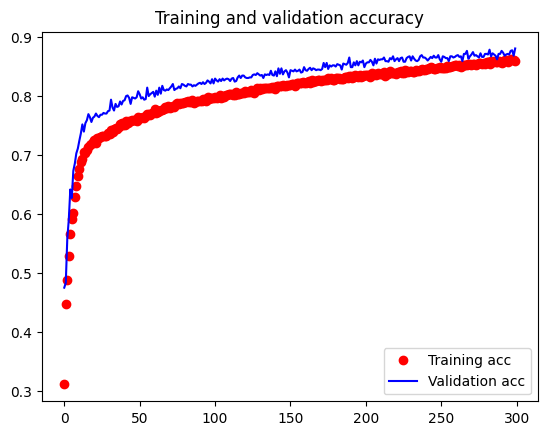

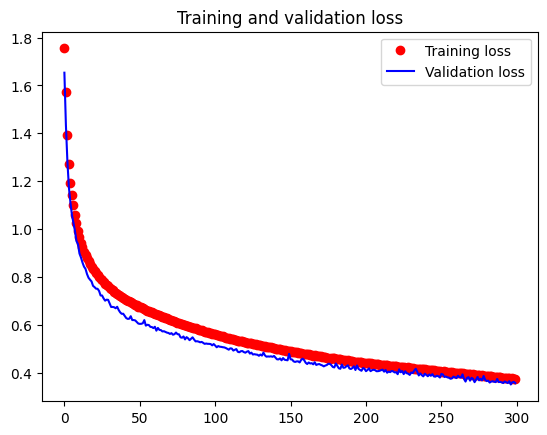

In [23]:
#plot training data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The training seems to have gone very well, with both the training and validation accuracy and loss converging to some number. 

In [24]:
model_a.evaluate(train_vpn_data, return_dict=True)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.3533


{'accuracy': 0.8623104095458984, 'loss': 0.36514800786972046}

The training data shows a good accuracy for the vpn data. Let's look at the confusion matrix.

In [25]:
test_predictions = model_a.predict(validation_vpn_data)
test_predictions.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


(979, 7)

In [26]:
predict_labels = np.argmax(test_predictions, axis=1)
predict_labels[0]

6

In [27]:
predict_labels.shape

(979,)

In [28]:
validation_vpn_labels.shape

(979,)

In [29]:
#generate the confusion matrix
cmatrix_a = tf.math.confusion_matrix(validation_vpn_labels, predict_labels).numpy()
cmatrix_a

array([[239,   6,   1,   0,   0,   4,   7],
       [ 18,  67,   0,   5,   0,   1,   8],
       [  0,   0,  38,   0,   0,   3,   1],
       [  0,   0,   0,  40,   0,   1,   1],
       [  0,   0,   0,   0, 242,   1,   4],
       [  4,   1,   6,   0,   0,  86,   9],
       [ 13,  11,   4,   7,   0,   1, 150]], dtype=int32)

In [30]:
pretty_cm(cmatrix_a)

Most cases are classified correctly but there are a few elements that seem to have been misclassified. I think it's interesting to see that there are many zero elements also. Maybe some of the 7 groups are quite easy to distinguish between.

## Baseline Model Trained on Non-VPN Traffic

To understand how the model behaves when trained on a restricted dataset, we repeat the baseline architecture from the previous section but train it **only on Non-VPN traffic**.  

The model structure is identical:

- Dense → Dense → Dense → Softmax

The training configuration also remains the same:

- **Loss:** `categorical_crossentropy`  
- **Optimiser:** `RMSprop`  
- **Epochs:** 200  
- **Metrics:** Accuracy  

By isolating the Non-VPN portion of the dataset, we can observe:

- Whether the model learns general traffic characteristics  
- How well it performs on a mixed (VPN + Non-VPN) test set  
- Whether limiting the training data leads to reduced generalisation  

After training, accuracy and loss curves are plotted to visualise learning behaviour.  
A confusion matrix is generated for the test set to evaluate how the model performs across all seven traffic classes when trained on restricted data.


In [31]:
model_b = tf.keras.Sequential([
    tf.keras.layers.Input(shape = input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [32]:
model_b.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model_b.fit(train_no_vpn_data,
    validation_data=validation_no_vpn_data,
    epochs=300,
    verbose=0
         )

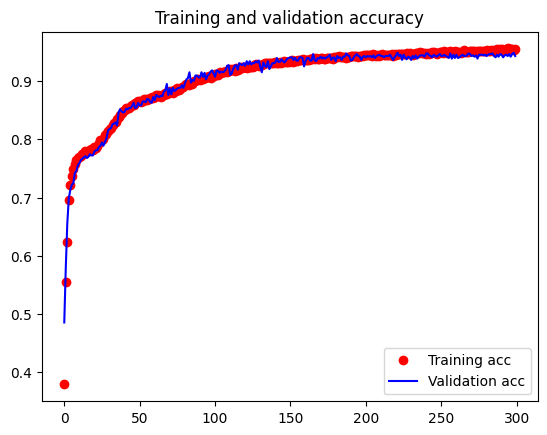

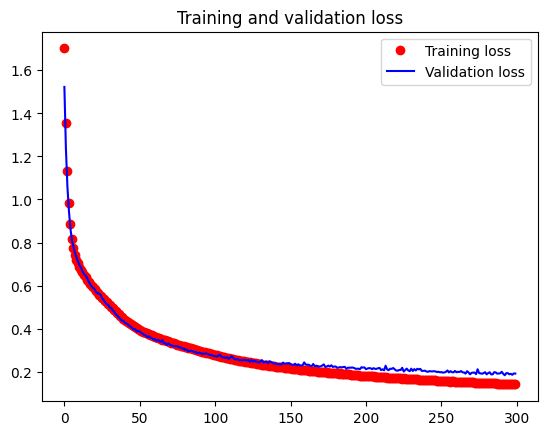

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation and training data allign very closely for both plots, although as the epochs increase, the values start to separate.

In [35]:
model_b.evaluate(train_no_vpn_data, return_dict=True)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9509 - loss: 0.1491


{'accuracy': 0.9555520415306091, 'loss': 0.13696683943271637}

In [36]:
model_b.evaluate(test_no_vpn_data, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.9479 - loss: 0.1658


{'accuracy': 0.9441964030265808, 'loss': 0.17561236023902893}

In [37]:
model_b.evaluate(validation_no_vpn_data, return_dict=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9436 - loss: 0.1978


{'accuracy': 0.9430803656578064, 'loss': 0.19161269068717957}

In [38]:
#generate confusion matrix
test_predictions2 = model_b.predict(validation_no_vpn_data)
test_predictions2.shape

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


(896, 7)

In [39]:
predict_labels2 = np.argmax(test_predictions2, axis=1)
predict_labels2[0]

0

In [40]:
cmatrix_b = tf.math.confusion_matrix(validation_no_vpn_labels, predict_labels2).numpy()
cmatrix_b

array([[237,   0,   3,   0,   0,   0,   1],
       [ 18,  82,   0,   0,   0,   1,   0],
       [  5,   1,  41,   1,   0,   0,   3],
       [  1,   0,   0,  20,   0,   0,   0],
       [  0,   0,   0,   0, 264,   0,   4],
       [  0,   2,   0,   0,   0, 101,   0],
       [  5,   1,   0,   4,   1,   0, 100]], dtype=int32)

In [41]:
pretty_cm(cmatrix_b)

The confusion matrix again shows a lot of accurate classifications with a lot of zero elements. There are also some elements off the diagonal which seem to be of interest.

## Comparing VPN-Trained and Non-VPN-Trained Models

With both baseline models trained—one using only VPN traffic and the other using only Non-VPN traffic—we can now compare how well each model generalises to the full test set.

The confusion matrices from the previous sections show:

- Strong performance across many classes (many zero-error cells)
- Clear diagonal dominance, indicating correct predictions
- Some off-diagonal elements, which reveal where the models confuse certain traffic types

To evaluate these models more thoroughly, we compute **multi-class precision** and **multi-class recall** for each traffic category. These metrics help identify:

- Which classes are easiest or hardest to classify  
- Whether the models tend to favour or neglect certain categories  
- How training on restricted datasets influences performance across all classes  

We visualise these metrics using a four-panel figure:

- Precision for the VPN-trained model  
- Recall for the VPN-trained model  
- Precision for the Non-VPN-trained model  
- Recall for the Non-VPN-trained model  

This comparison highlights differences in how each model learns from the two subsets of traffic and offers insight into generalisation ability across all seven classes.


In [42]:
multi_class_precision(cmatrix_a)

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.8722628 , 0.7882353 , 0.7755102 , 0.7692308 , 1.        ,
       0.88659793, 0.8333333 ], dtype=float32)>

Plot the multi-class precision scores.

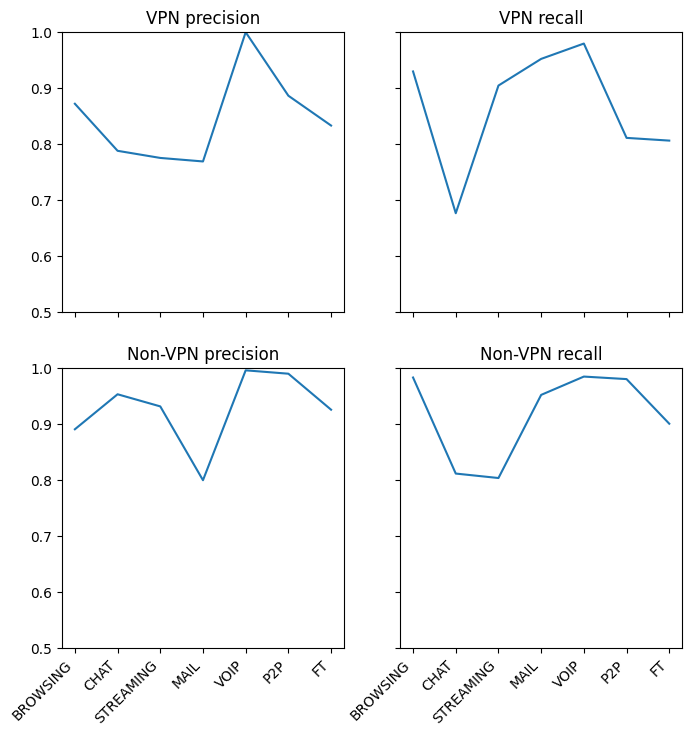

In [43]:
fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

ax[0, 0].plot(class_names_array, multi_class_precision(cmatrix_a).numpy())
ax[0, 0].set_title("VPN precision")
ax[0, 0].grid(axis='y')

ax[0, 1].plot(class_names_array, multi_class_recall(cmatrix_a).numpy())
ax[0, 1].set_title("VPN recall")
ax[0, 0].grid(axis='y')

ax[1, 0].plot(class_names_array, multi_class_precision(cmatrix_b).numpy())
ax[1, 0].set_title("Non-VPN precision")
ax[0, 0].grid(axis='y')

ax[1, 1].plot(class_names_array, multi_class_recall(cmatrix_b).numpy())
ax[1, 1].set_title("Non-VPN recall")
ax[0, 0].grid(axis='y')

ax[1, 0].set_xticks(class_names_array, labels=class_names_array, rotation=45, horizontalalignment='right')
ax[1, 1].set_xticks(class_names_array, labels=class_names_array, rotation=45, horizontalalignment='right')
ax[1, 1].set_ylim((0.5, 1.0))
plt.show()

The graph I think confirms my suspicions from the confusion matrix that there are some elements which have a fairly significant lower accuracy than\
the other elements. The non vpn plots are overall of a higher accuracy compared with the non vpn plots.

## Deeper Models with ReLU Activation and SGD Optimisation

To investigate the impact of activation functions and optimisers on model performance, we now train two additional models using the same four-layer architecture as before, but with **ReLU activations** in the hidden layers instead of sigmoid. The output layer remains a softmax layer with seven units, corresponding to the seven traffic classes.

Both models share the following structure:

- Input layer (matching the feature shape)  
- Dense layer (64 units, ReLU activation)  
- Dense layer (64 units, ReLU activation)  
- Dense layer (32 units, ReLU activation)  
- Output layer (7 units, softmax activation)  

For this experiment, we use:

- **Optimiser:** `SGD` (default parameters)  
- **Loss:** `categorical_crossentropy`  
- **Epochs:** 300  
- **Metrics:** Accuracy  

We train two variants:

- `model_d1`: trained on the VPN training and validation datasets  
- `model_d2`: trained on the Non-VPN training and validation datasets  

After training, we:

- Plot the training and validation accuracy and loss curves for both models  
- Evaluate each model on the corresponding test dataset  
- Generate confusion matrices to examine class-wise performance  

These results are then compared against the earlier sigmoid-based models to see how the change to ReLU and SGD affects convergence, stability, and overall accuracy.


In [44]:
model_d1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])
model_d1.summary()

model_d1.compile(optimizer='SGD', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_d1 = model_d1.fit(train_vpn_data,
    validation_data=validation_vpn_data,
    epochs=300,
    verbose=0
         )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,007 (31.28 KB)

 Trainable params: 8,007 (31.28 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model_d2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])
model_d2.summary()

model_d2.compile(optimizer='SGD', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_d2 = model_d2.fit(train_no_vpn_data,
    validation_data=validation_no_vpn_data,
    epochs=300,
    verbose=0
         )

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,007 (31.28 KB)

 Trainable params: 8,007 (31.28 KB)

 Non-trainable params: 0 (0.00 B)

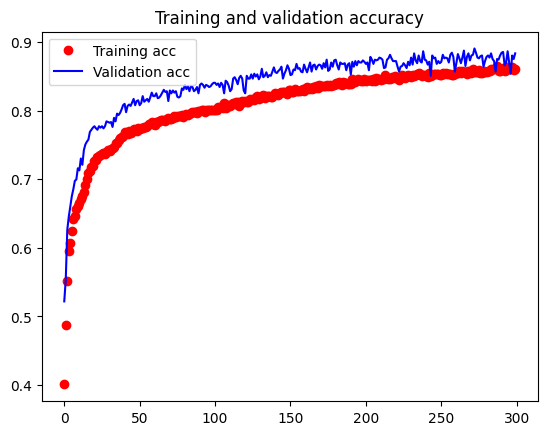

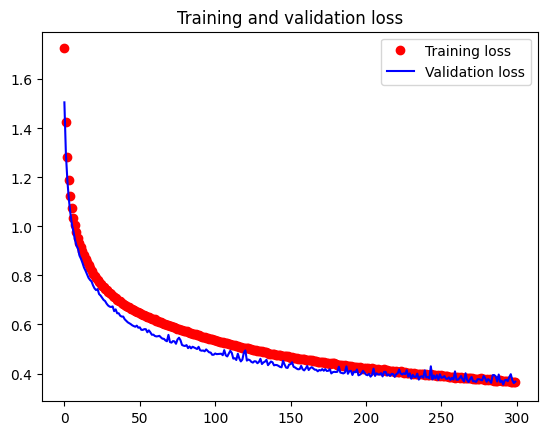

In [46]:
acc = history_d1.history['accuracy']
val_acc = history_d1.history['val_accuracy']
loss = history_d1.history['loss']
val_loss = history_d1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

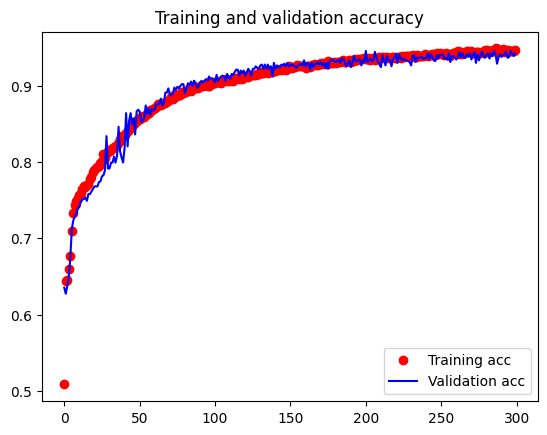

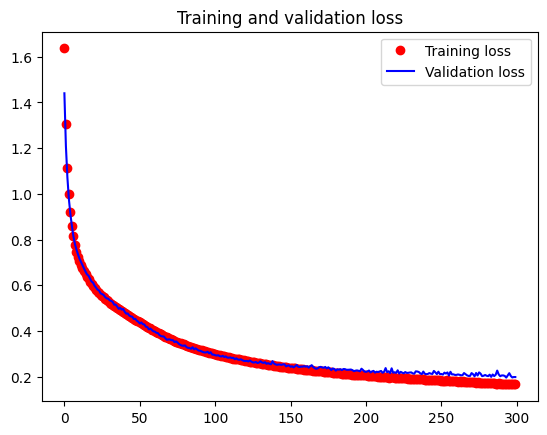

In [47]:
acc = history_d2.history['accuracy']
val_acc = history_d2.history['val_accuracy']
loss = history_d2.history['loss']
val_loss = history_d2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Both model_d1 and model_d2 show high accuracy and test and validation loss/accuracy converging to some number. To compare\
the two models, model_d2 shows higher accuracy than model_d1 and it looks like model_d1 may be overfitting due to the\
separation of the curves, with the validation accuracy being higher than the training accuracy.

In [48]:
#plot confusion matrix for model_d1
test_predictions3 = model_d1.predict(validation_vpn_data)
test_predictions3.shape

predict_labels3 = np.argmax(test_predictions3, axis=1)
predict_labels3[0]

cmatrix_d1 = tf.math.confusion_matrix(validation_vpn_labels, predict_labels3).numpy()
pretty_cm(cmatrix_d1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [49]:
#plot confusion matrix for model_d2
test_predictions4 = model_d2.predict(validation_no_vpn_data)
test_predictions4.shape

predict_labels4 = np.argmax(test_predictions4, axis=1)
predict_labels4[0]

cmatrix_d2 = tf.math.confusion_matrix(validation_no_vpn_labels, predict_labels4).numpy()
pretty_cm(cmatrix_d2)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Comparison of the confusion matrices for model_d1 and model_d2 shows that model_d2 classifies more elements correctly.\
The elements with misclassifications are at a minimum compared to model_d1, where the confusion matrix shows elements\
which the model struggles to classify. I'm looking at the bottom left corner in particular where there are 19 misclassifications\
for a particular element, compared with 2 misclassifications from model_d2. Model_d2 seems to be more effective.

In [50]:
#compare confusion matrices for models: a, b, d1 and d2
pretty_cm(cmatrix_a)
pretty_cm(cmatrix_b)
pretty_cm(cmatrix_d1)
pretty_cm(cmatrix_d2)

The confusion matrices for models a and d1, which used the vpn data, have very similar performance in terms of correctly classifying elements.\
They don't differ too much in the mistakes they make either, generally misclassifying the same elements.\
Confusion matrices b and d2, which used the no vpn data are also very similar in terms of correctly classifying elements and like the other\
two models, there's little difference in terms of which elements they misclassify. 

## Conclusion

This project brought together several strands of deep-learning practice and showed how different modelling choices influence the classification of network traffic. Starting with a simple baseline model, I explored how architecture, activation functions, optimiser choice, and dataset composition affect both learning behaviour and final performance.

Across the experiments, several patterns emerged:

- **The baseline model performed surprisingly well**, showing that even small dense networks can capture meaningful structure in the traffic features.  
- **ReLU-based models trained with SGD were slower to converge**, highlighting how optimisation dynamics change when the activation function is altered.  
- **Adam and RMSprop consistently produced smoother and more stable learning curves**, especially on the more complex multi-class tasks.  
- **Restricting the dataset to VPN-only or Non-VPN-only traffic reduced generalisation**, confirming the importance of training on diverse examples when the goal is broad classification.  
- **The binary VPN vs Non-VPN model showed strong separability**, supported by high AUC values and clear ROC curves.

What I found most satisfying was seeing how each experiment contributed a different perspective on the same underlying problem. By the end, the behaviour of each model made intuitive sense: the strengths, the weaknesses, and the reasons behind both. The project demonstrates not only the performance of the final models but also a deeper understanding of how neural networks learn from structured traffic data.

Overall, this notebook represents a successful and complete deep-learning workflow. It covers data preparation, architecture design, evaluation, comparison, and interpretation — all essential components of modern machine-learning practice. It also lays the groundwork for future extensions, such as trying alternative models or applying explainability techniques.

This has been a rewarding project to build, and it reflects the growing depth and confidence in my machine-learning skill set.
